In [1]:
%pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
GIZd = h5py.File('./data/CGM-profiles-progenitors_evoz.hdf5','r')

In [40]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: particle type (default 0)
'''

def cal_sta_profiles(mod,d,snap,region,ntclu,part = 0):
    nbin = 150
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    allm500 = np.zeros(ntclu)
    
    #Note: the row is nor responding to cluster number
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    print('redshift: ', redshift, 'snapshot: ', snap)
    i = 0
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        if mod == 'G3X':
            allm500[i] = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500'] * 1.0e10
        else:
            allm500[i] = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
                 
#         if region == 'Stellardens' or region == 'Totdens':
#             allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
#             rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / 1000 #unit:Mpc/h
        if region == 'Veldisp' or region == 'NuminBin':
            allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][part]
            rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        else:
            allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
            rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        i+=1
        
    if region == 'Pressure':
        from astropy import units
        keVtoerg = (units.keV).to('erg') 
        #if model == 'G3X': m500 * 1e10
        p500 = (allm500 / 1e15)**(2/3) * 1.45e-11  #P500 in units: erg*cm^-3
        p500 = p500.reshape(ntclu,1)
        allvalue = allvalue * 0.6777**3 * keVtoerg / p500
    
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    for j in range(nbin):
        nonan = np.where((allvalue[:,j]!= 0) & (np.isnan(allvalue[:,j]) == False))[0]
        ymed[j] = np.median(allvalue[nonan,j])
        xmed[j] = np.median(rbinvalue[nonan,j])
        if len(nonan):
            yerrtot = np.percentile(allvalue[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

# Cluster number at different redshift

In [ ]:
# def exist_cluster(d,snap): 
    sn_sa_red=np.loadtxt('/home2/weiguang/Project-300-Clusters/redshifts.txt')
    nclu = 0
    for i in range(324):
        if 'Rbin' in d['NewMDCLUSTER_0%03d/snap_%03d'%(i+1, snap)]:
            nclu += 1
        else:
            print('no exist cluster number is', i+1)
    print('redshift: ',sn_sa_red[snap,2].round(3),'cluster number: ', nclu)

exist_cluster(GIZd,128)
exist_cluster(GIZd,95)
exist_cluster(GIZd,78)
exist_cluster(GIZd,55)


# Particle number in each bin

<IPython.core.display.Javascript object>


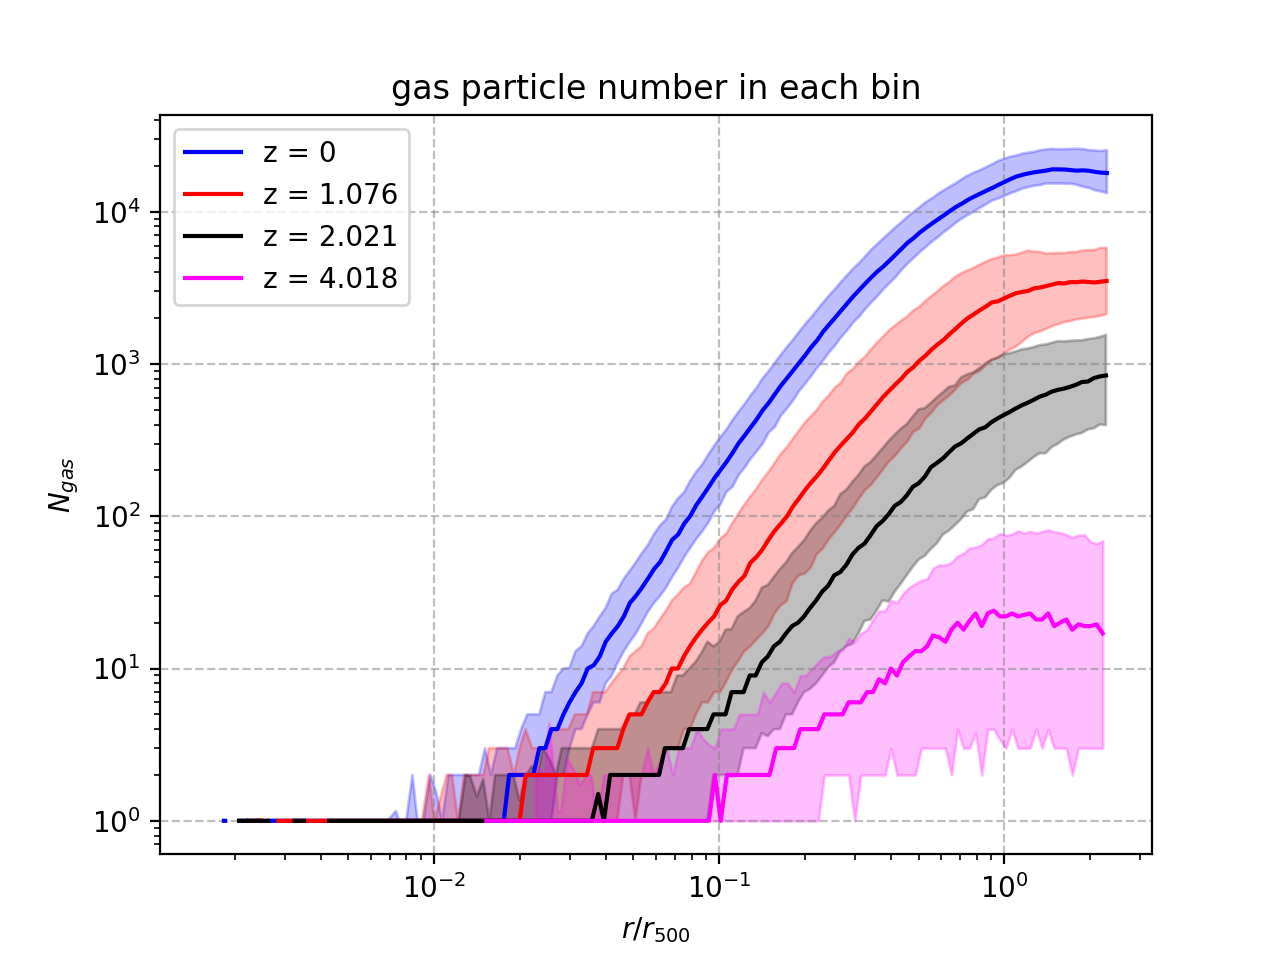

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
#gas particle number in each bin

plt.figure()
plt.title('gas particle number in each bin')

#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'NuminBin',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'NuminBin',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'NuminBin',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'NuminBin',323) 
plt.plot(xmed,ymed,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$N_{gas}$')
plt.loglog()
plt.legend()
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# Gas density

<IPython.core.display.Javascript object>


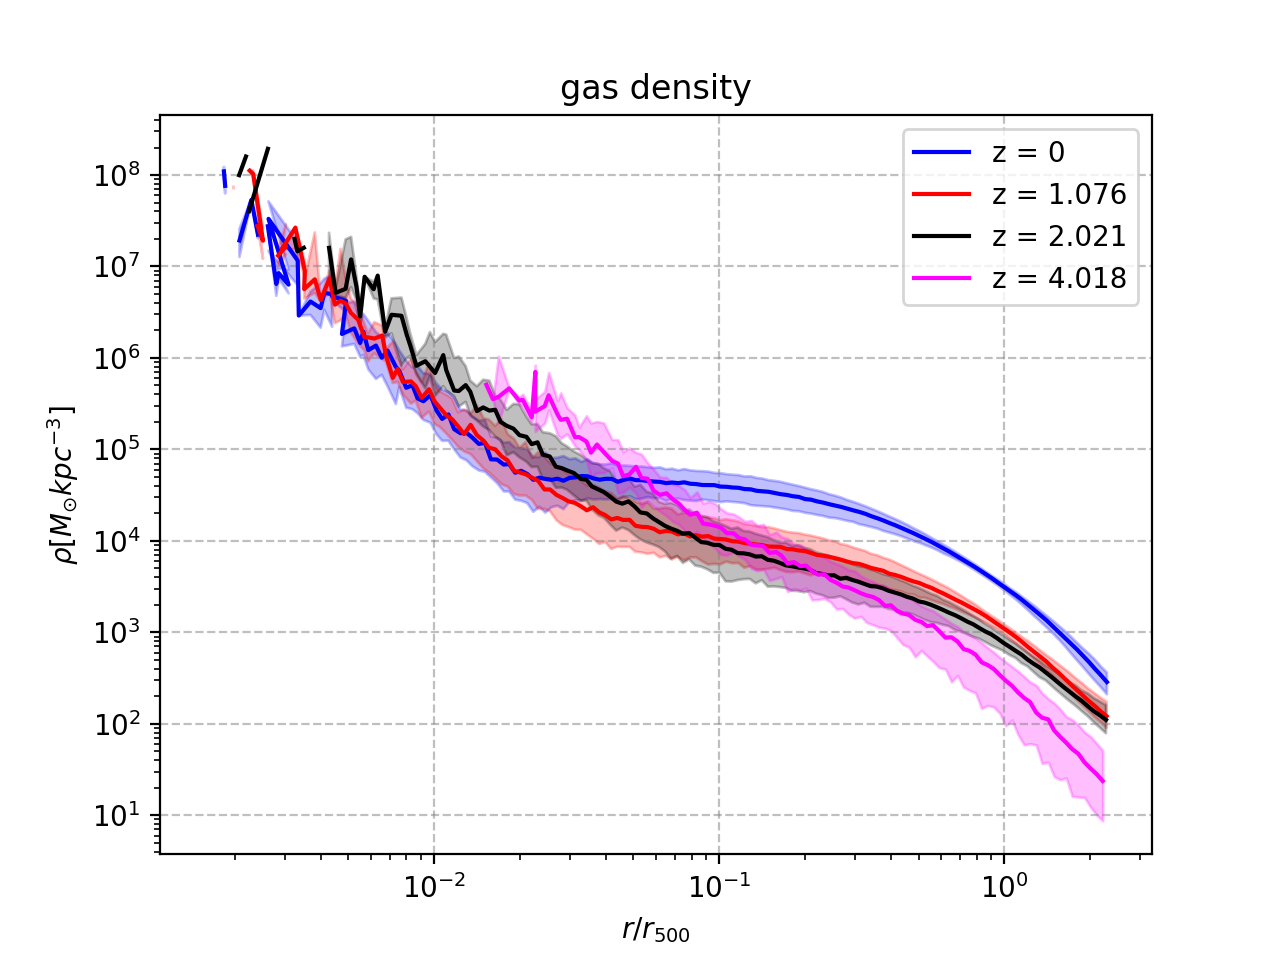

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
#gas density
plt.figure()
plt.title('gas density')

#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Gdens',324)
gdens = ymed * 0.6777**2
yerrdown = yerr[0] *  0.6777**2
yerrup = yerr[1] *  0.6777**2
plt.plot(xmed,gdens,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Gdens',324)
gdens = ymed * 0.6777**2
yerrdown = yerr[0] *  0.6777**2
yerrup = yerr[1] *  0.6777**2
plt.plot(xmed,gdens,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Gdens',323)
gdens = ymed * 0.6777**2
yerrdown = yerr[0] *  0.6777**2
yerrup = yerr[1] *  0.6777**2
plt.plot(xmed,gdens,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Gdens',323)
gdens = ymed * 0.6777**2
yerrdown = yerr[0] *  0.6777**2
yerrup = yerr[1] *  0.6777**2
plt.plot(xmed,gdens,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\rho[M_{\odot}kpc^{-3}]$')
plt.loglog()
plt.legend()
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
# plt.ylim(1e2,1e6)
# plt.savefig('/Users/liqy/Desktop/Gdens.pdf')

<IPython.core.display.Javascript object>


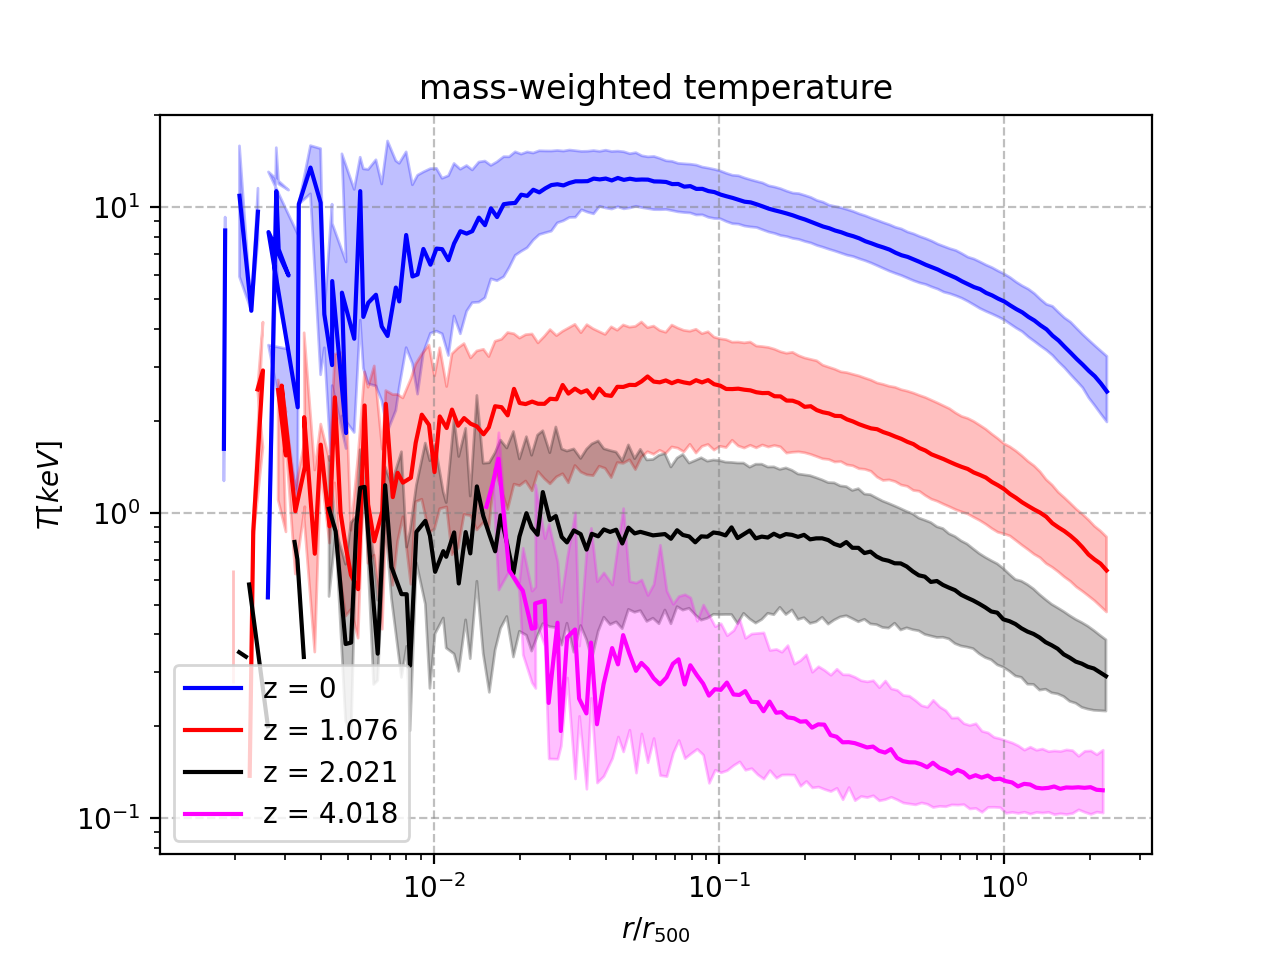

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-11-3e822c06979c>:46: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,20)


In [11]:
#temperature

plt.figure()
plt.title('mass-weighted temperature')

#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'MWTemp',324)
temp = ymed 
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,temp,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'MWTemp',324)
temp = ymed
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,temp,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'MWTemp',323)
temp = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,temp,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'MWTemp',323)
temp = ymed
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,temp,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$T[keV]$')
# plt.xscale('log')
plt.loglog()
# plt.axvline(r200,c = 'k',ls ='--',label = 'r200')
# plt.axvline(r500,c = 'grey',ls ='--',label = 'r500')
plt.legend()
plt.ylim(0,20)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# plt.savefig('/Users/liqy/Desktop/Temp.pdf')

# Pressure

<IPython.core.display.Javascript object>


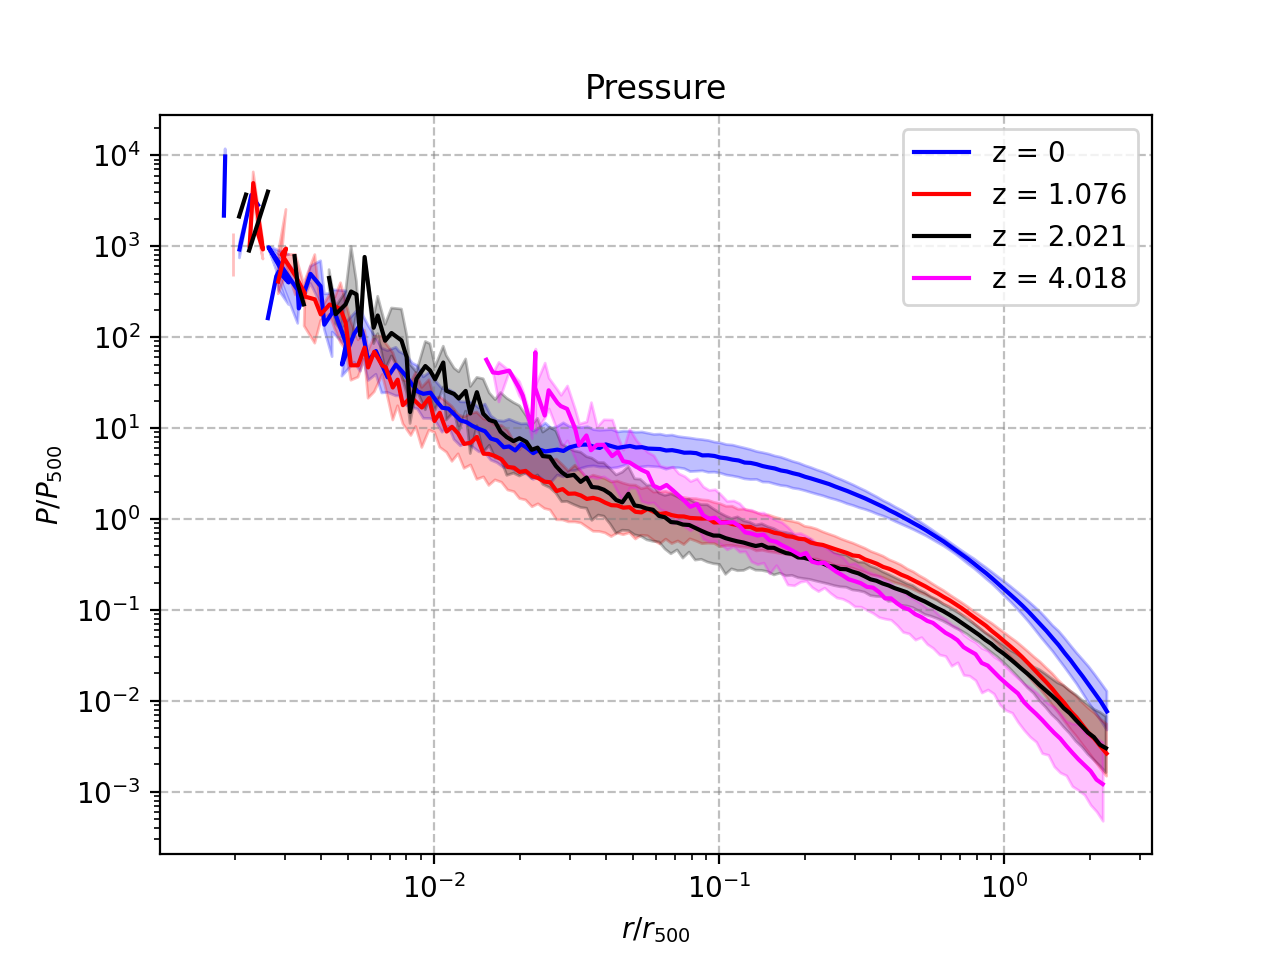

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
#pressure

plt.figure()
plt.title('Pressure')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Pressure',324)
pressure = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1] 
plt.plot(xmed,pressure,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Pressure',324)
pressure = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1] 
plt.plot(xmed,pressure,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Pressure',323)
pressure = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,pressure,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Pressure',323)
pressure = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,pressure,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$P/P_{500}$')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.loglog()
plt.legend()

# Metallicity

<IPython.core.display.Javascript object>


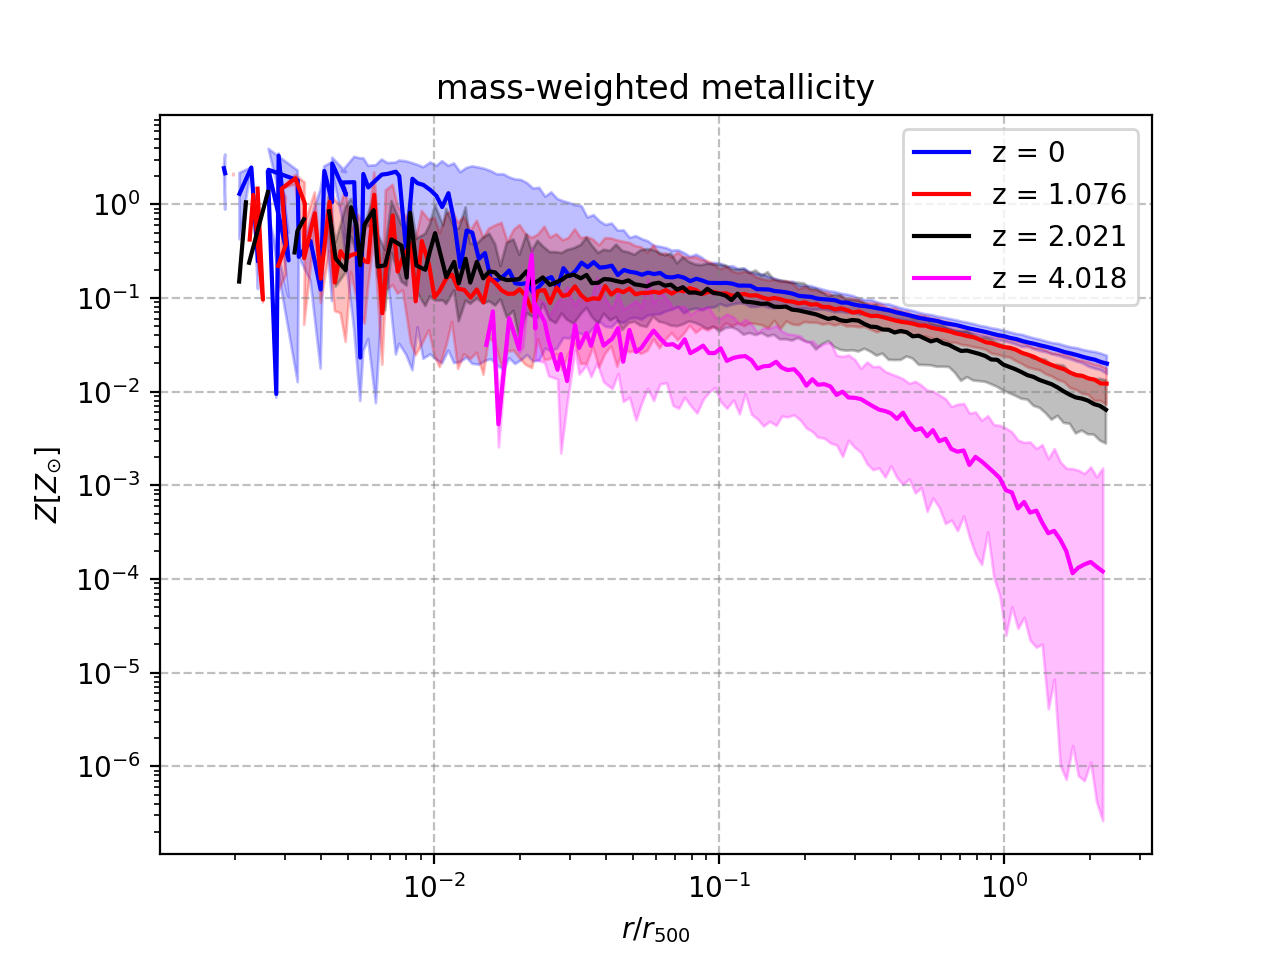

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
#mass-weighted metallicity

plt.figure()
plt.title('mass-weighted metallicity')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'MWMetal',324)
metal = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,metal,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'MWMetal',324)
metal = ymed
yerrdown = yerr[0]
yerrup = yerr[1] 
plt.plot(xmed,metal,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'MWMetal',323)
metal = ymed
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,metal,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'MWMetal',323)
metal = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1] 
plt.plot(xmed,metal,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$Z[Z_{\odot}]$')
plt.legend()
plt.loglog()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# Electron number density

<IPython.core.display.Javascript object>


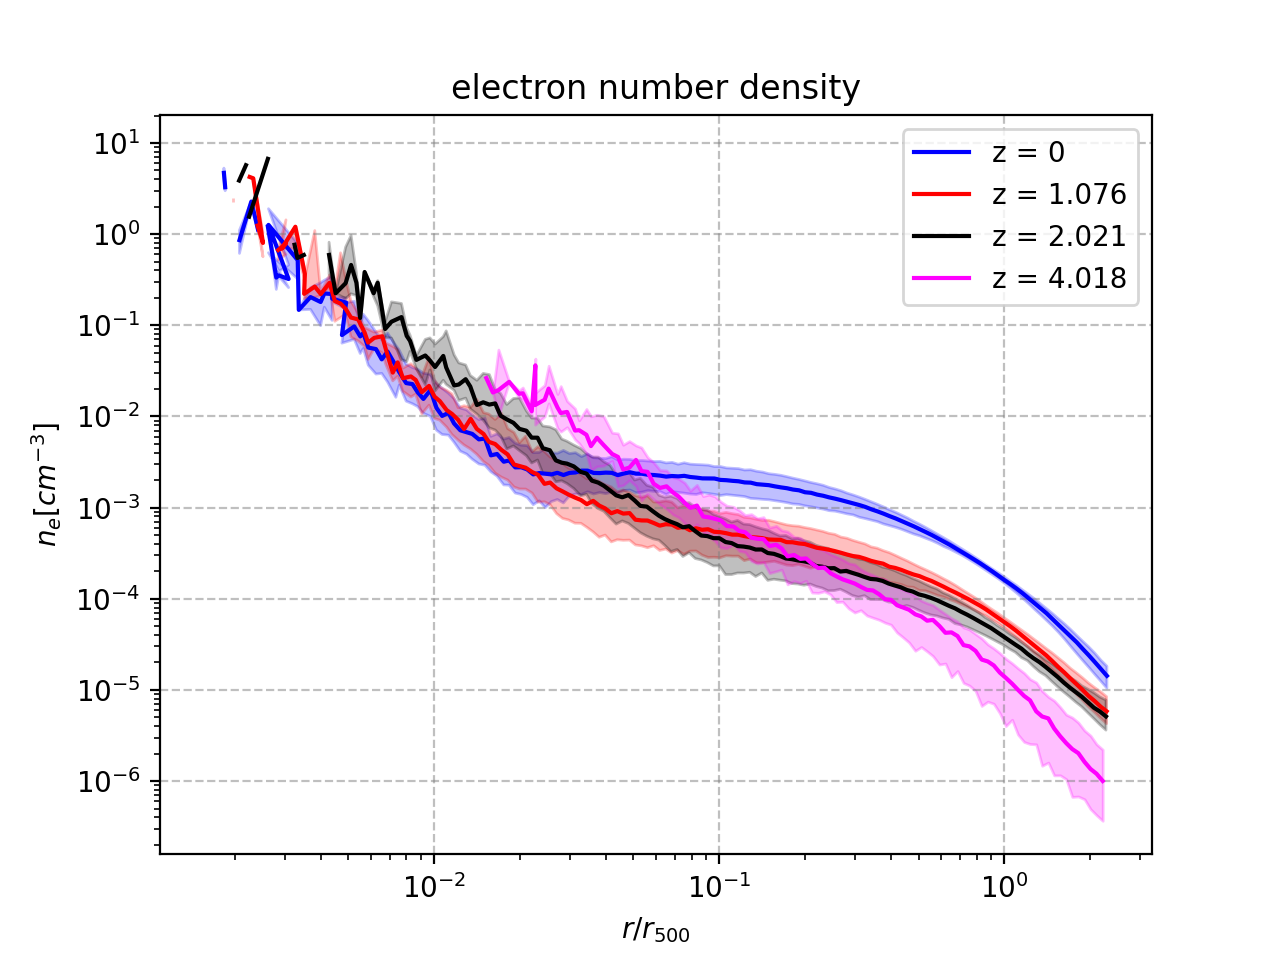

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
#electron number density

plt.figure()
plt.title('electron number density')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Eledens',324)
ele = ymed *0.6777**3
yerrdown = yerr[0] *0.6777**3
yerrup = yerr[1] *0.6777**3
plt.plot(xmed,ele,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Eledens',324)
ele = ymed *0.6777**3
yerrdown = yerr[0] *0.6777**3
yerrup = yerr[1] *0.6777**3
plt.plot(xmed,ele,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Eledens',323)
ele = ymed *0.6777**3
yerrdown = yerr[0] *0.6777**3
yerrup = yerr[1] *0.6777**3
plt.plot(xmed,ele,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Eledens',323)
ele = ymed *0.6777**3
yerrdown = yerr[0] *0.6777**3
yerrup = yerr[1] *0.6777**3
plt.plot(xmed,ele,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$n_e[cm^{-3}]$')
plt.loglog()
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# Entropy

<IPython.core.display.Javascript object>


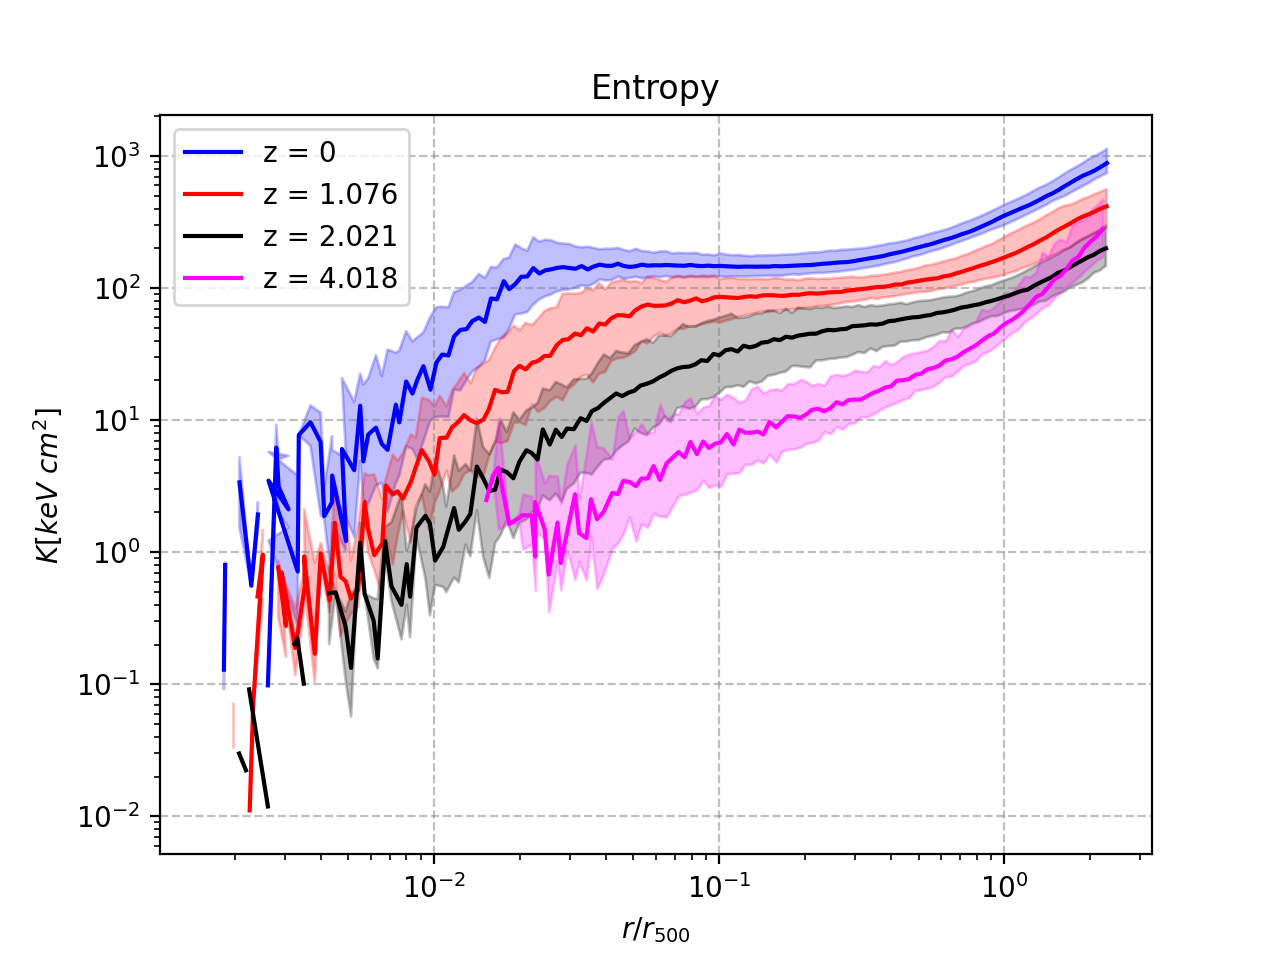

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
#Entropy

plt.figure()
plt.title('Entropy')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Entropy',324)
entro = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,entro,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Entropy',324)
entro = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,entro,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Entropy',323)
entro = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,entro,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Entropy',323)
entro = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,entro,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$K[keV\ cm^2]$')
plt.loglog()
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# stellar mass density

<IPython.core.display.Javascript object>


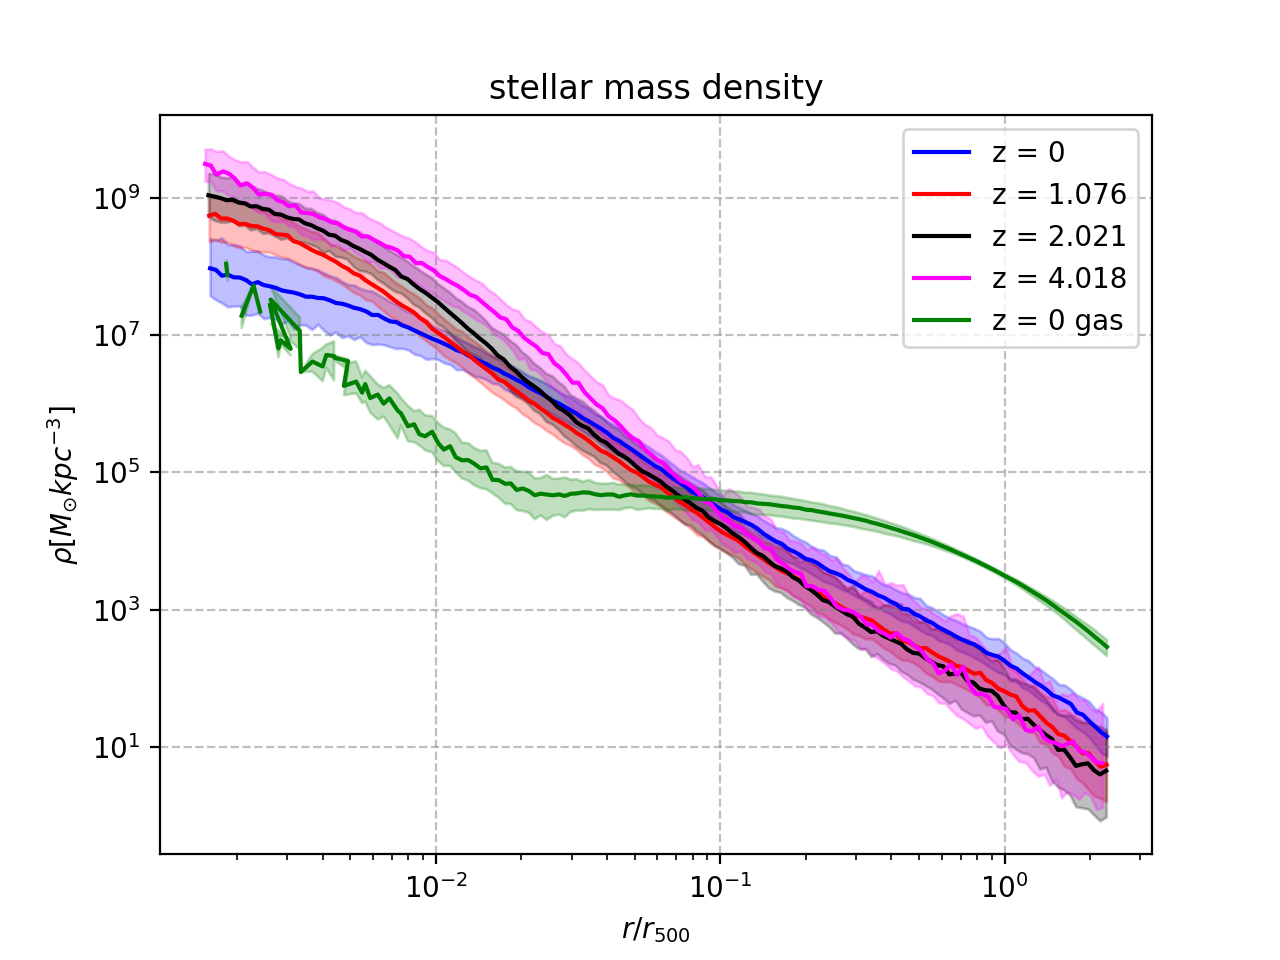

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95
redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55
redshift:  0.0 snapshot:  128


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
#stellar mass density

plt.figure()
plt.title('stellar mass density')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Stellardens',324)
stedens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,stedens,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Stellardens',324)
stedens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,stedens,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Stellardens',323)
stedens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,stedens,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Stellardens',323)
stedens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,stedens,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)

xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Gdens',324)
gas0 = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,gas0,c='green',label = 'z = 0 gas')
plt.fill_between(xmed,yerrdown,yerrup,color = 'green',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\rho[M_{\odot}kpc^{-3}]$')
plt.loglog()
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# total mass density

<IPython.core.display.Javascript object>


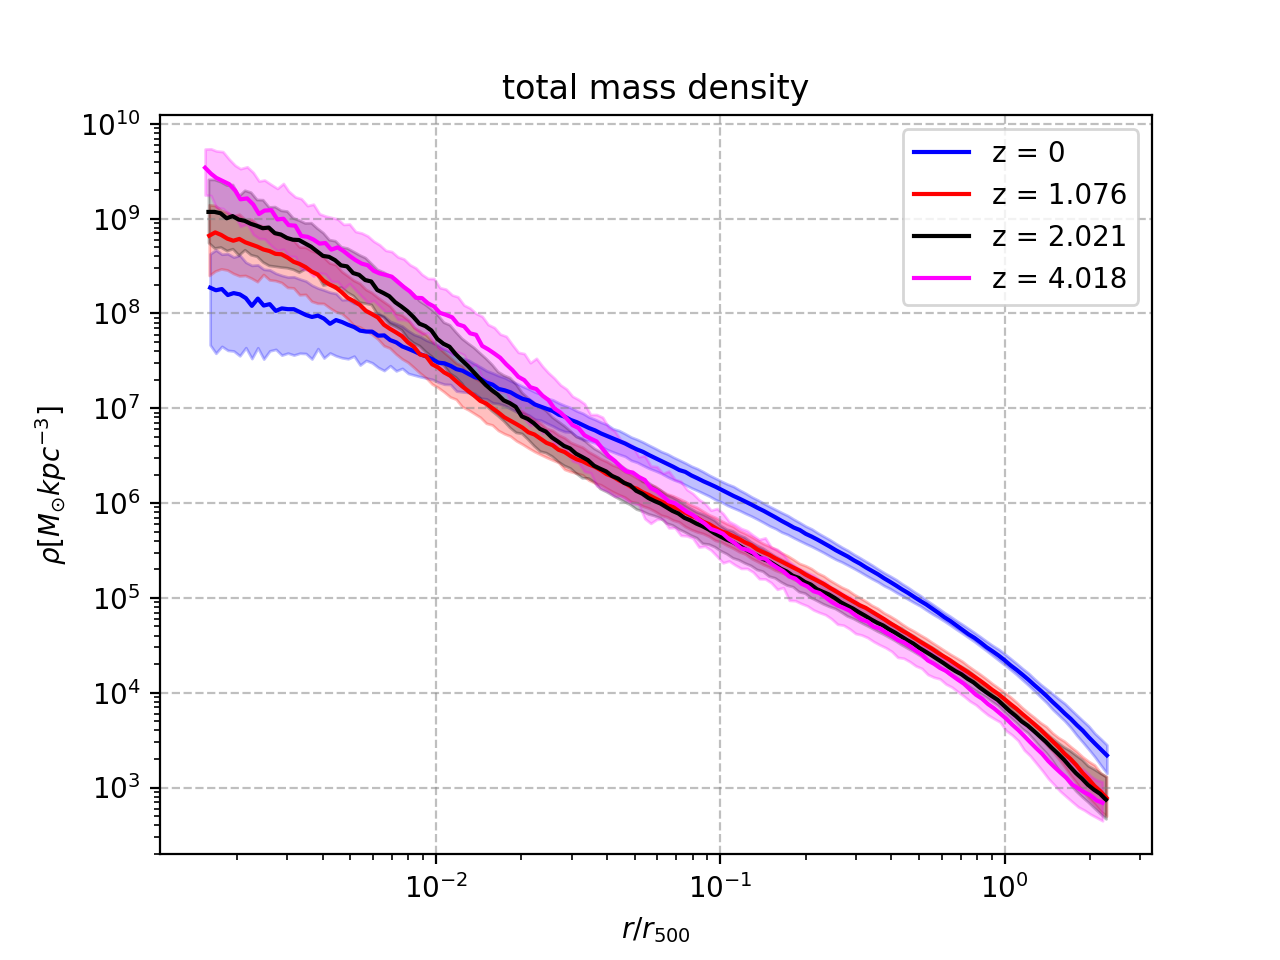

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95
redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


In [28]:
#stellar mass density

plt.figure()
plt.title('total mass density')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Totdens',324)
totdens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,totdens,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Totdens',324)
totdens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,totdens,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Totdens',323)
totdens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,totdens,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Totdens',323)
totdens = ymed *0.6777**2
yerrdown = yerr[0] *0.6777**2
yerrup = yerr[1] *0.6777**2
plt.plot(xmed,totdens,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\rho[M_{\odot}kpc^{-3}]$')
plt.loglog()
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# Potential

<IPython.core.display.Javascript object>


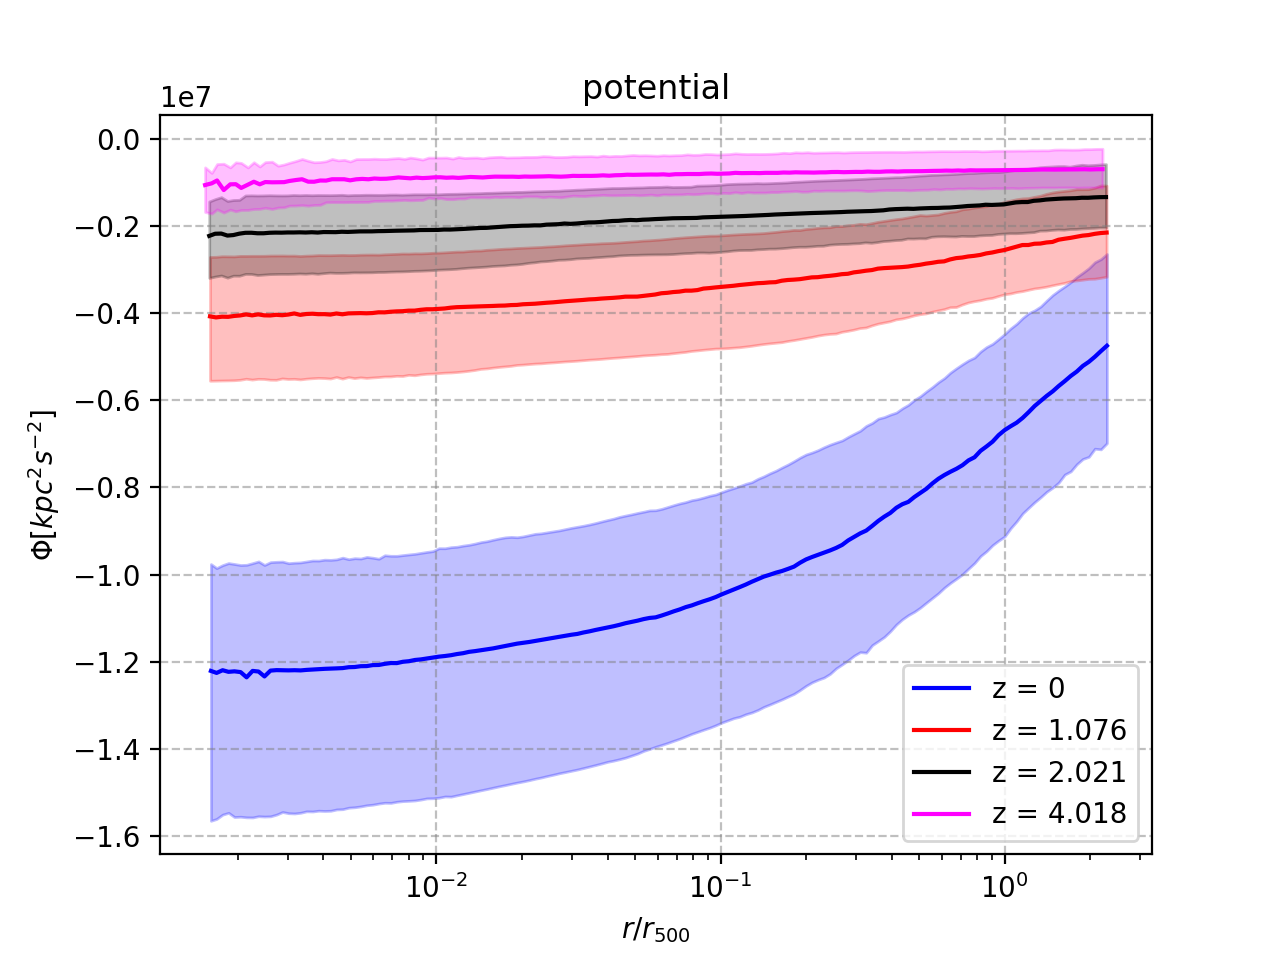

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95
redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


In [43]:
plt.figure()
plt.title('potential')

#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Potential',324)
pot = ymed
yerrdown = yerr[0] 
yerrup = yerr[1] 
plt.plot(xmed,pot,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Potential',324)
pot = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,pot,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Potential',323)
pot = ymed
yerrdown = yerr[0] 
yerrup = yerr[1] 
plt.plot(xmed,pot,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Potential',323)
pot = ymed 
yerrdown = yerr[0] 
yerrup = yerr[1]
plt.plot(xmed,pot,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$\Phi[kpc^2s^{-2}]$')
# plt.loglog()
plt.xscale('log')
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

# velocity dispersion

<IPython.core.display.Javascript object>


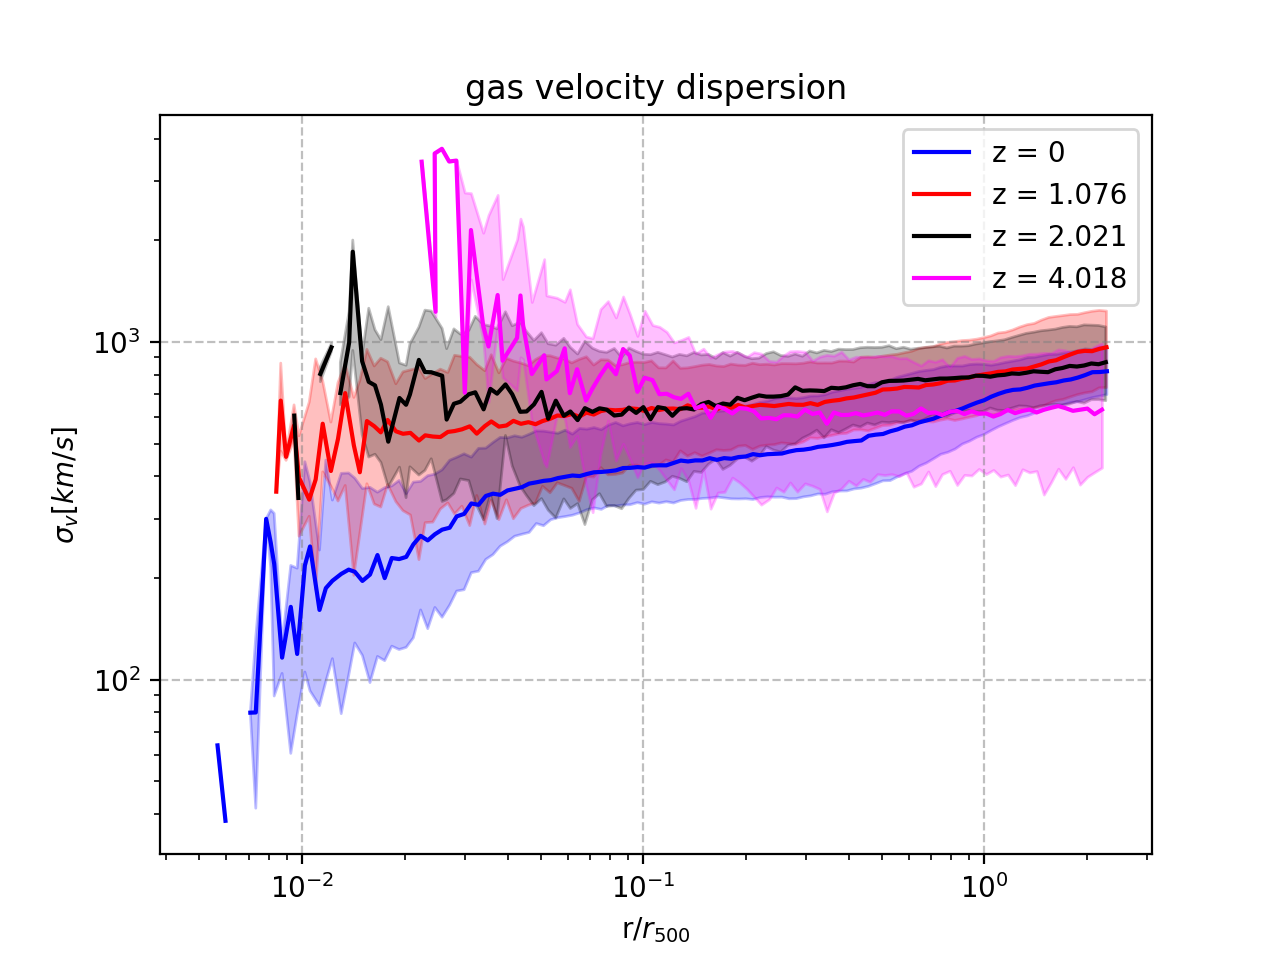

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
#gas velocity dispersion

plt.figure()
plt.title('gas velocity dispersion')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Veldisp',324)
vdgas = ymed 
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Veldisp',324)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Veldisp',323)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Veldisp',323)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel('r/$r_{500}$')
plt.ylabel(r'$\sigma_v[km/s]$')
plt.loglog()
plt.legend()

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

<IPython.core.display.Javascript object>


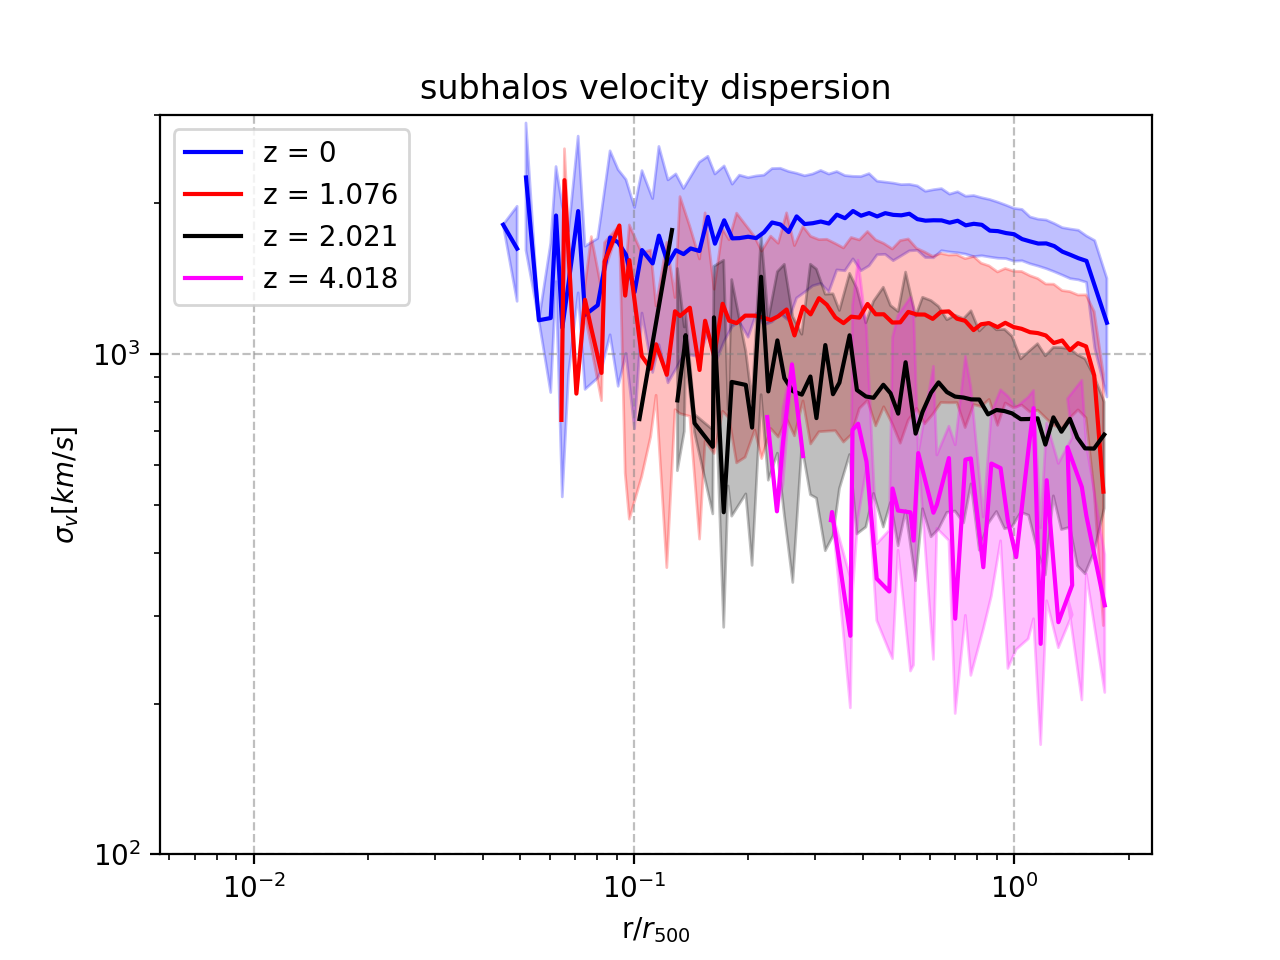

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
#subhalos velocity dispersion

plt.figure()
plt.title('subhalos velocity dispersion')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Veldisp',324,1)
vdgas = ymed 
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Veldisp',324,1)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Veldisp',323,1)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Veldisp',323,1)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel('r/$r_{500}$')
plt.ylabel(r'$\sigma_v[km/s]$')
plt.loglog()
plt.legend()
plt.ylim(1e2,3000)

plt.grid(c = 'grey', ls = '--', alpha = 0.5)

<IPython.core.display.Javascript object>


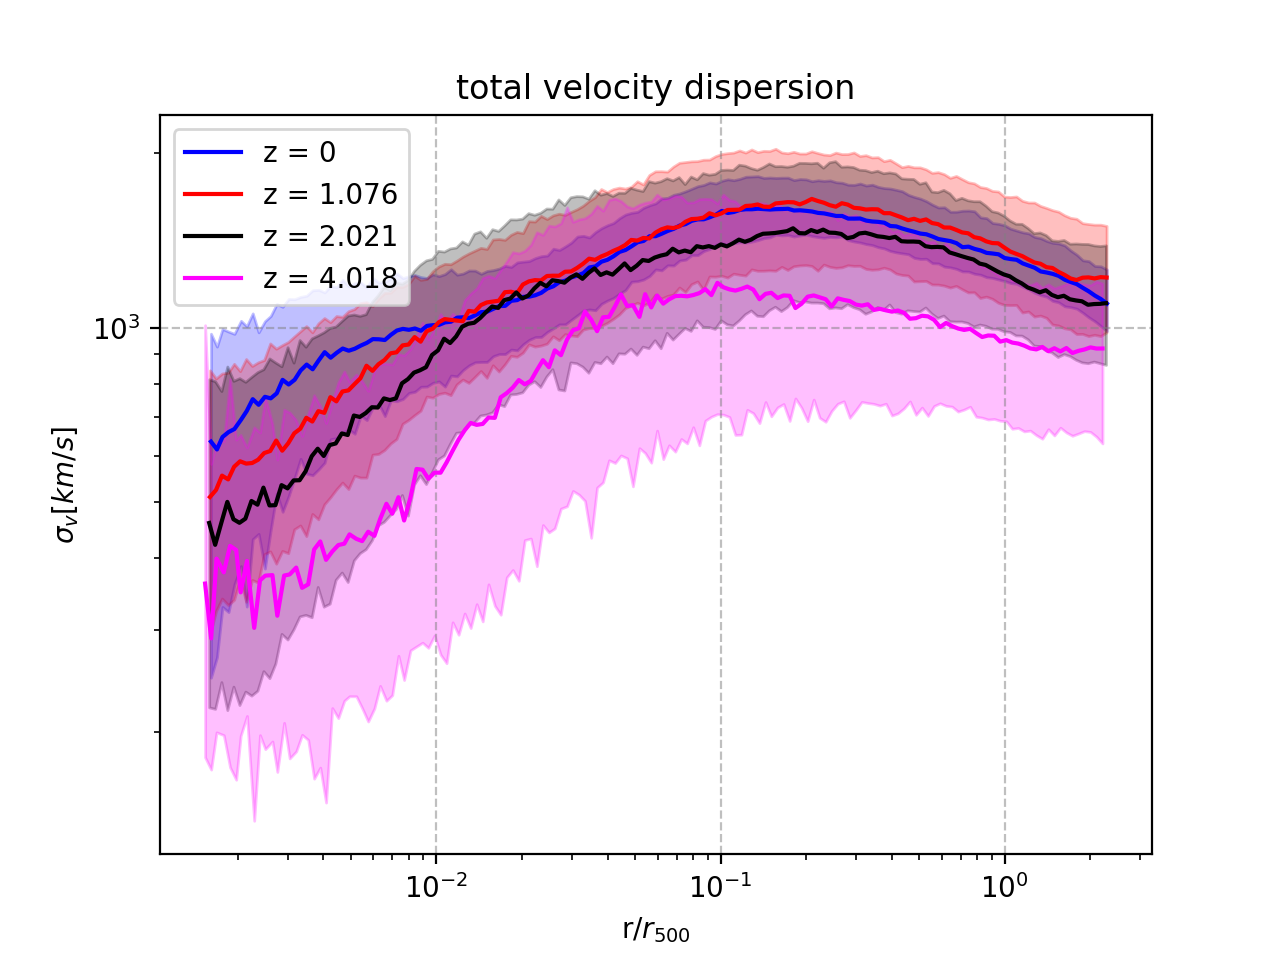

redshift:  0.0 snapshot:  128
redshift:  1.076147198677063 snapshot:  95
redshift:  2.0213561058044434 snapshot:  78
redshift:  4.017714977264404 snapshot:  55


In [37]:
#total velocity dispersion

plt.figure()
plt.title('total velocity dispersion')


#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Veldisp',324,2)
vdgas = ymed 
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='b',label = 'z = 0')
plt.fill_between(xmed,yerrdown,yerrup,color = 'b',alpha = 0.25)

#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Veldisp',324,2)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerrdown,yerrup,color = 'r',alpha = 0.25)

#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Veldisp',323,2)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerrdown,yerrup,color = 'k',alpha = 0.25)

#z = 4.018
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,55,'Veldisp',323,2)
vdgas = ymed
yerrdown = yerr[0]
yerrup = yerr[1]
plt.plot(xmed,vdgas,c='magenta',label = 'z = 4.018')
plt.fill_between(xmed,yerrdown,yerrup,color = 'magenta',alpha = 0.25)


plt.xlabel('r/$r_{500}$')
plt.ylabel(r'$\sigma_v[km/s]$')
plt.loglog()
plt.legend(loc = 'best')

plt.grid(c = 'grey', ls = '--', alpha = 0.5)